# Data preparation

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from progressbar import progressbar as pb
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(4)

In [2]:
df = pd.read_csv('data/train.csv')
print(len(df))
df.head()

2000


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
chosen_features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'n_cores', \
                   'pc', 'ram', 'talk_time', 'touch_screen', 'wifi', 'price_range']
len(chosen_features)

14

In [5]:
newdf = df[chosen_features]

df_0 = newdf[newdf['price_range'] == 0]
df_3 = newdf[newdf['price_range'] == 1]

final_df = pd.concat([df_0, df_3])
final_df.reset_index(drop=True, inplace=True)

In [6]:
final_df.to_csv('data.csv')

# Code

In [7]:
df = pd.read_csv('data.csv', index_col=0)

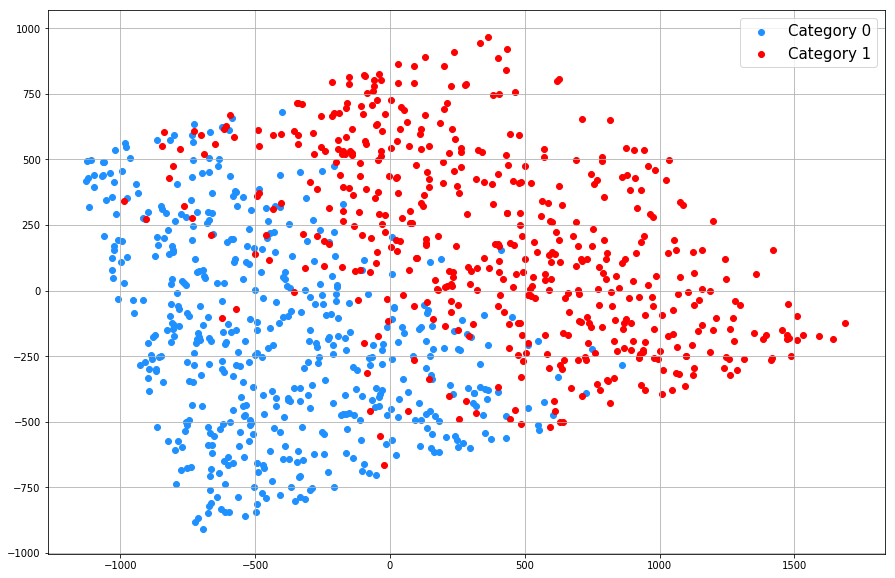

In [9]:
pca = PCA(n_components=2)

X = pca.fit_transform(df.iloc[:,:-1])

fig = plt.figure(figsize=(15,10))
plt.scatter(X[:500,0], X[:500,1], c='dodgerblue', label='Category 0')
plt.scatter(X[500:,0], X[500:,1], c='red', label='Category 1')
plt.legend(fontsize=15)
plt.grid()

# pp = PdfPages('pca.pdf', keep_empty=False)
# pp.savefig(fig)
# pp.close()

In [11]:
bins = ['blue', 'dual_sim', 'four_g', 'touch_screen', 'wifi', 'price_range']
num_bins = np.array([50,5,5,50,8,25,20,18])
bins_d = {i:bins[i] for i in range(len(bins))}
bins_d

{0: 'blue',
 1: 'dual_sim',
 2: 'four_g',
 3: 'touch_screen',
 4: 'wifi',
 5: 'price_range'}

In [14]:
numerical = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'n_cores', 'pc', 'ram', 'talk_time']
binary = list(set(df.columns) - set(numerical))

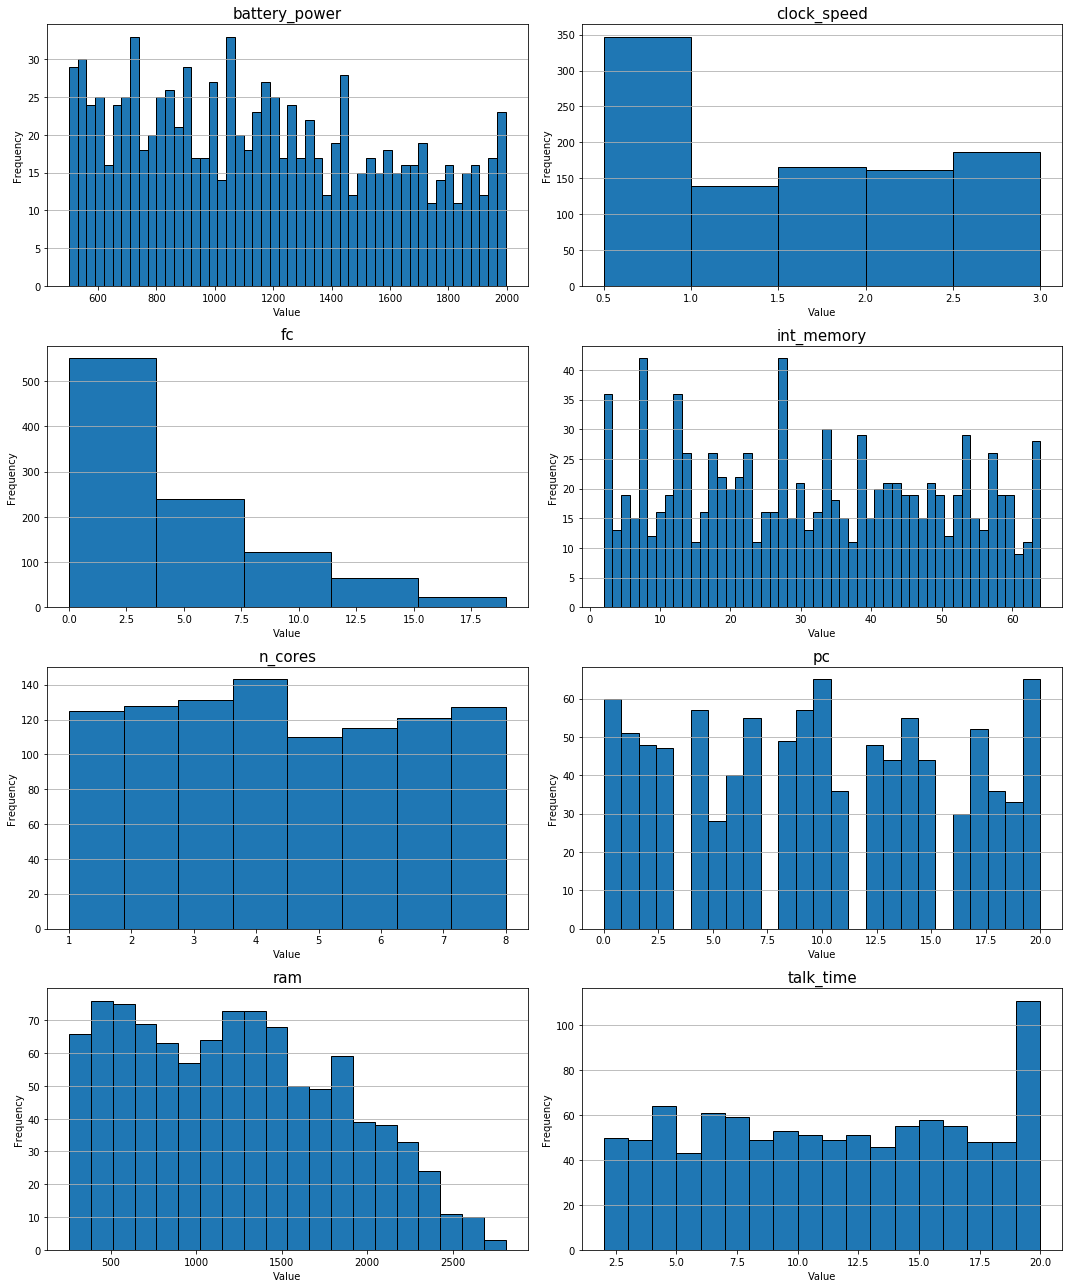

In [15]:
cat_plot = np.array(numerical).reshape(-1,2)
bin_plot = np.array(num_bins).reshape(-1,2)

fig, axs = plt.subplots(4, 2)
fig.set_figheight(18)
fig.set_figwidth(15)

for i in range(cat_plot.shape[0]):
    for j in range(cat_plot.shape[1]):
        axs[i,j].set_title(cat_plot[i,j], size=15)
        axs[i,j].hist(df[cat_plot[i,j]], bins=bin_plot[i,j], edgecolor='black', linewidth=1)
        axs[i,j].set_xlabel('Value', size=10)
        axs[i,j].set_ylabel('Frequency', size=10)
        axs[i,j].grid(axis='y')
        
fig.tight_layout()

In [19]:
pivots = {'battery_power':[1000, 1300, 1750],
         'clock_speed': None,
         'fc': None,
         'int_memory': [15, 25, 37, 47],
         'n_cores': np.arange(1.5, 8, 1).tolist(),
         'pc': [3.5, 7.5, 11.5, 15.5],
         'ram': None,
         'talk_time': [7, 11, 16]}

In [16]:
import LazyLearning
from importlib import reload
reload(LazyLearning)
from LazyLearning import LazyLearner

# Logistic regression

In [1085]:
lazy = LazyLearner(df, numerical, binary)

best_score, best_c, best_pen = {'f1':0}, 0, 0

c_vals = np.logspace(-3,3,7)
pen_vals = ["l1","l2"]

for c in pb(c_vals):
    for pen in pen_vals:
        result = lazy.calc_logreg_metrics(c_val=c, penalty=pen)
        if result.get('f1') > best_score.get('f1'):
            best_score = result
            best_c = c
            best_pen = pen
            
print('Best C:', best_c)
print('Best penalty:', best_pen)
best_score

N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


Best C: 10.0
Best penalty: l1


{'roc_auc': 0.9002403846153846,
 'accuracy': 0.9,
 'precision': 0.9117647058823529,
 'recall': 0.8942307692307693,
 'f1': 0.9029126213592232}

# Random forest

In [1087]:
lazy = LazyLearner(df, numerical, binary)

estim_val = np.arange(10, 110, 10)
depth_val = np.arange(5, 30, 5)
leaf_val = np.arange(1, 6, 1)

best_score, best_estim, best_depth, best_leaf = {'f1':0}, 0, 0, 0

for estim in pb(estim_val):
    for depth in depth_val:
        for leaf in leaf_val:
            result = lazy.calc_forest_metrics(estim=estim, depth=depth, leaf=leaf)
            if result.get('f1') > best_score.get('f1'):
                best_score = result
                best_estim = estim
                best_depth = depth
                best_leaf = leaf
                
print('Best n_estimators:', best_estim)
print('Best max_depth:', best_depth)
print('Best min_samples_leaf:', best_leaf)
best_score

100% (10 of 10) |########################| Elapsed Time: 0:01:02 Time:  0:01:02


Best n_estimators: 40
Best max_depth: 10
Best min_samples_leaf: 3


{'roc_auc': 0.9006410256410255,
 'accuracy': 0.9,
 'precision': 0.92,
 'recall': 0.8846153846153846,
 'f1': 0.9019607843137256}

# Mean
## Simple pivots

In [1074]:
lazy = LazyLearner(df, numerical, binary)
result_base = lazy.calc_lazy_metrics()
result_base

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


{'roc_auc': 0.921875,
 'accuracy': 0.925,
 'precision': 0.8739495798319328,
 'recall': 1.0,
 'f1': 0.9327354260089686}

## Custom pivots

In [1075]:
lazy = LazyLearner(df, numerical, binary, pivots)
result_pro = lazy.calc_lazy_metrics()
result_pro

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


{'roc_auc': 0.9427083333333333,
 'accuracy': 0.945,
 'precision': 0.9043478260869565,
 'recall': 1.0,
 'f1': 0.9497716894977168}

# Median
## Simple pivots

In [21]:
lazy = LazyLearner(df, numerical, binary)
result_median = lazy.calc_lazy_metrics('median')
result_median

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


{'roc_auc': 0.9600000000000001,
 'accuracy': 0.96,
 'precision': 0.9259259259259259,
 'recall': 1.0,
 'f1': 0.9615384615384615}

## Custom pivots

In [20]:
lazy = LazyLearner(df, numerical, binary, pivots)
result_median = lazy.calc_lazy_metrics('median')
result_median

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


{'roc_auc': 0.9550000000000001,
 'accuracy': 0.955,
 'precision': 0.9174311926605505,
 'recall': 1.0,
 'f1': 0.9569377990430622}

# Max
## Simple pivots

In [31]:
lazy = LazyLearner(df, numerical, binary)
result_max = lazy.calc_lazy_metrics('max')
result_max

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


{'roc_auc': 0.9090909090909091,
 'accuracy': 0.91,
 'precision': 0.8487394957983193,
 'recall': 1.0,
 'f1': 0.9181818181818181}

## Custom pivots

In [28]:
lazy = LazyLearner(df, numerical, binary, pivots)
result_max = lazy.calc_lazy_metrics('max')
result_max

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


{'roc_auc': 0.904040404040404,
 'accuracy': 0.905,
 'precision': 0.8416666666666667,
 'recall': 1.0,
 'f1': 0.9140271493212669}

# Threshold = 0.5
## Simple pivots mean 

In [1088]:
lazy = LazyLearner(df, numerical, binary, threshold=0.5)
result_tr_05 = lazy.calc_lazy_metrics()
result_tr_05

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.7732371794871795,
 'accuracy': 0.78,
 'precision': 0.7205882352941176,
 'recall': 0.9423076923076923,
 'f1': 0.8166666666666668}

## Custom pivots mean

In [1089]:
lazy = LazyLearner(df, numerical, binary, pivots, threshold=0.5)
result_tr_05 = lazy.calc_lazy_metrics()
result_tr_05

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.7736378205128205,
 'accuracy': 0.78,
 'precision': 0.7238805970149254,
 'recall': 0.9326923076923077,
 'f1': 0.8151260504201682}

## Simple pivots median

In [32]:
lazy = LazyLearner(df, numerical, binary, threshold=0.5)
result_tr_05 = lazy.calc_lazy_metrics('median')
result_tr_05

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.55,
 'accuracy': 0.55,
 'precision': 0.5543478260869565,
 'recall': 0.51,
 'f1': 0.5312500000000001}

## Custom pivots median

In [33]:
lazy = LazyLearner(df, numerical, binary, pivots, threshold=0.5)
result_tr_05 = lazy.calc_lazy_metrics('median')
result_tr_05

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.585,
 'accuracy': 0.585,
 'precision': 0.5876288659793815,
 'recall': 0.57,
 'f1': 0.5786802030456853}

# Threshold = 0.3
## Simple pivots mean

In [1090]:
lazy = LazyLearner(df, numerical, binary, threshold=0.3)
result_tr_03 = lazy.calc_lazy_metrics()
result_tr_03

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.7247596153846154,
 'accuracy': 0.725,
 'precision': 0.7378640776699029,
 'recall': 0.7307692307692307,
 'f1': 0.7342995169082126}

## Custom pivots mean

In [1102]:
lazy = LazyLearner(df, numerical, binary, pivots, threshold=0.3)
result_tr_03 = lazy.calc_lazy_metrics()
result_tr_03

100% (200 of 200) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.6858974358974358,
 'accuracy': 0.685,
 'precision': 0.711340206185567,
 'recall': 0.6634615384615384,
 'f1': 0.6865671641791045}

## Simple pivots median

In [34]:
lazy = LazyLearner(df, numerical, binary, threshold=0.3)
result_tr_03 = lazy.calc_lazy_metrics('median')
result_tr_03

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.52,
 'accuracy': 0.52,
 'precision': 0.5163934426229508,
 'recall': 0.63,
 'f1': 0.5675675675675675}

## Custom pivots median

In [35]:
lazy = LazyLearner(df, numerical, binary, pivots, threshold=0.3)
result_tr_03 = lazy.calc_lazy_metrics('median')
result_tr_03

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'roc_auc': 0.505,
 'accuracy': 0.505,
 'precision': 0.504,
 'recall': 0.63,
 'f1': 0.56}

# Weighted mean
## Simple pivots

In [1147]:
import LazyLearning
from importlib import reload
reload(LazyLearning)
from LazyLearning import LazyLearner

lazy = LazyLearner(df, numerical, binary)
result_weighted = lazy.calc_lazy_metrics('weighted_mean')
result_weighted

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
100% (800 of 800) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


{'roc_auc': 0.9947916666666667,
 'accuracy': 0.995,
 'precision': 0.9904761904761905,
 'recall': 1.0,
 'f1': 0.9952153110047847}

## Custom pivots

In [1148]:
import LazyLearning
from importlib import reload
reload(LazyLearning)
from LazyLearning import LazyLearner

lazy = LazyLearner(df, numerical, binary, pivots)
result_weighted = lazy.calc_lazy_metrics('weighted_mean')
result_weighted

100% (200 of 200) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
100% (800 of 800) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


{'roc_auc': 0.9947916666666667,
 'accuracy': 0.995,
 'precision': 0.9904761904761905,
 'recall': 1.0,
 'f1': 0.9952153110047847}

# ------